<a href="https://colab.research.google.com/github/salmakishk98/PharmacyWepsite/blob/main/faceMask.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install kaggle

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"zeinabsalem","key":"82e8de1cc490a84066a7e3f4d63f0986"}'}

In [ ]:
!mkdir ~/.kaggle
!cp /content/kaggle.json ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download -d omkargurav/face-mask-dataset

 99% 161M/163M [00:04<00:00, 41.8MB/s]
100% 163M/163M [00:04<00:00, 38.3MB/s]


In [ ]:
from zipfile import ZipFile
file_name = "/content/face-mask-dataset.zip"
with ZipFile(file_name , 'r')as zip:
  zip.extractall()
  print('done')

done


In [ ]:
import os
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor

data_dir = '/content/data'
dataset = ImageFolder(data_dir, transform=ToTensor())
print(len(dataset))
print(dataset.classes)

7553
['with_mask', 'without_mask']


Label:  with_mask (0)


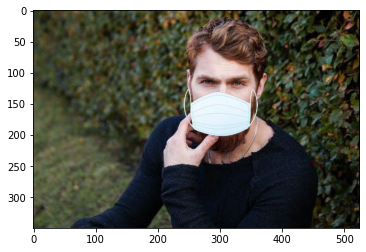

In [ ]:
import torch
import matplotlib.pyplot as plt
%matplotlib inline

def show_example(img, label):
    print('Label: ', dataset.classes[label], "("+str(label)+")")
    plt.imshow(img.permute(1, 2, 0))  

show_example(*dataset[0])

In [ ]:
import torchvision.transforms as tt
image_size = (32,32)
stats = ([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
dataset = ImageFolder(data_dir, tt.Compose([
    tt.Resize(image_size),
    tt.ToTensor(),
    tt.Normalize(*stats)
]))

In [ ]:
from torch.utils.data import random_split
val_pct = 0.1
val_size = int(val_pct * len(dataset))

train_ds, valid_ds = random_split(dataset, [len(dataset) - val_size, val_size])

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


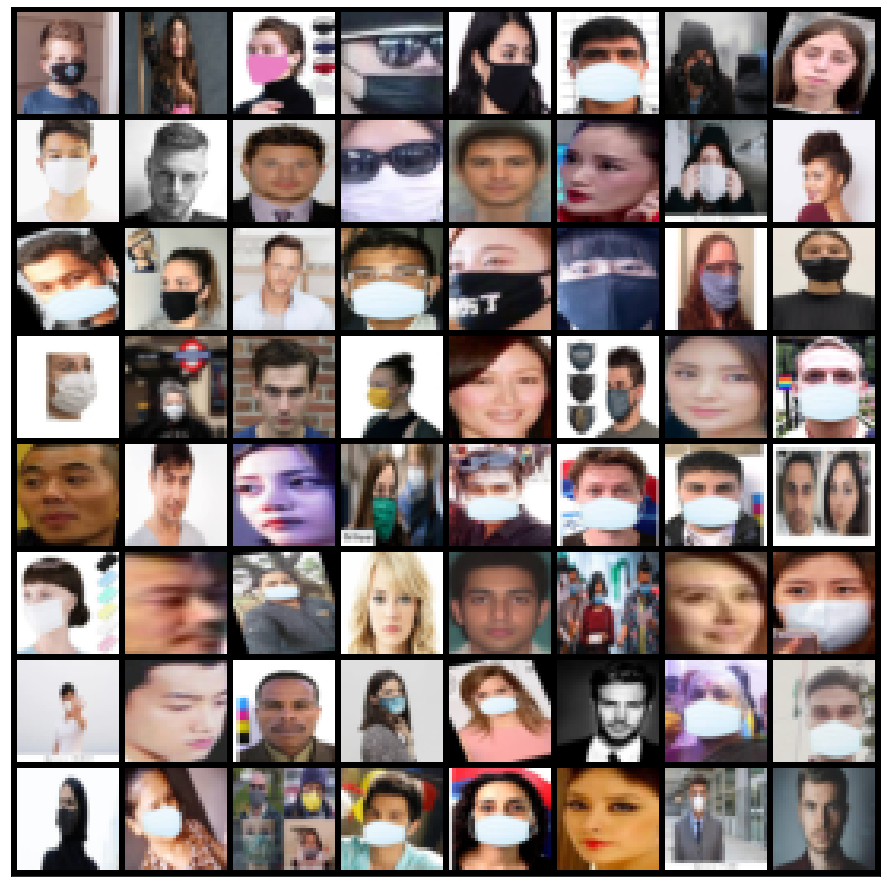

In [ ]:
from torch.utils.data import DataLoader
batch_size = 256

train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
valid_dl = DataLoader(valid_ds, batch_size*2, num_workers=4, pin_memory=True)

from torchvision.utils import make_grid
def denormalize(images, means, stds):
    if len(images.shape) == 3:
        images = images.unsqueeze(0)
    means = torch.tensor(means).reshape(1, 3, 1, 1)
    stds = torch.tensor(stds).reshape(1, 3, 1, 1)
    return images * stds + means

def show_image(img_tensor, label):
    print('Label:', dataset.classes[label], '(' + str(label) + ')')
    img_tensor = denormalize(img_tensor, *stats)[0].permute((1, 2, 0))
    plt.imshow(img_tensor)

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(16, 16))
        ax.set_xticks([]); ax.set_yticks([])
        images = denormalize(images[:64], *stats)
        ax.imshow(make_grid(images, nrow=8).permute(1, 2, 0))
        break
show_batch(train_dl)

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels)  # Calculate loss
        return loss

    def validation_step(self, batch):
        images, labels = batch
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    def epoch_end(self, epoch, result):
        print("Epoch [{}],{} train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, "last_lr: {:.5f},".format(result['lrs'][-1]) if 'lrs' in result else '', 
            result['train_loss'], result['val_loss'], result['val_acc']))

In [ ]:
import torch
from tqdm.notebook import tqdm

@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase
        model.train()
        train_losses = []
        for batch in tqdm(train_loader):
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader,
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []

    # Set up custom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs,
                                                steps_per_epoch=len(train_loader))

    for epoch in range(epochs):
        # Training Phase
        model.train()
        train_losses = []
        lrs = []
        for batch in tqdm(train_loader):
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()

            # Gradient clipping
            if grad_clip:
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            optimizer.step()
            optimizer.zero_grad()

            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [ ]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)


In [ ]:
from torchvision import models
models.resnet34(pretrained=True)


class MasksModel(ImageClassificationBase):

    def __init__(self, num_classes, pretrained=True):
        super().__init__()
        # Use a pretrained model
        self.network = models.resnet34(pretrained=pretrained) #downloading weights from this model when it was trained on ImageNet dataset
        # Replace last layer
        self.network.fc = nn.Linear(self.network.fc.in_features, num_classes)

    def forward(self, xb):
        return self.network(xb)

model = MasksModel(len(dataset.classes), pretrained=True)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)
model = model.to(device)

history = [evaluate(model, valid_dl)]
epochs = 15
max_lr = 0.001
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam
history += fit_one_cycle(epochs, max_lr, model, train_dl, valid_dl, 
                         grad_clip=grad_clip, 
                         weight_decay=weight_decay, 
                         opt_func=opt_func)

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


  0%|          | 0/27 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Epoch [0],last_lr: 0.00015, train_loss: 0.4918, val_loss: 0.2352, val_acc: 0.9031


  0%|          | 0/27 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Epoch [1],last_lr: 0.00043, train_loss: 0.1271, val_loss: 0.1343, val_acc: 0.9580


  0%|          | 0/27 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Epoch [2],last_lr: 0.00076, train_loss: 0.0627, val_loss: 0.1017, val_acc: 0.9641


  0%|          | 0/27 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Epoch [3],last_lr: 0.00097, train_loss: 0.0753, val_loss: 0.1122, val_acc: 0.9561


  0%|          | 0/27 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Epoch [4],last_lr: 0.00099, train_loss: 0.0487, val_loss: 0.1078, val_acc: 0.9721


  0%|          | 0/27 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Epoch [5],last_lr: 0.00095, train_loss: 0.0299, val_loss: 0.1375, val_acc: 0.9640


  0%|          | 0/27 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Epoch [6],last_lr: 0.00087, train_loss: 0.0171, val_loss: 0.1187, val_acc: 0.9689


  0%|          | 0/27 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Epoch [7],last_lr: 0.00075, train_loss: 0.0087, val_loss: 0.0936, val_acc: 0.9789


  0%|          | 0/27 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Epoch [8],last_lr: 0.00061, train_loss: 0.0036, val_loss: 0.1056, val_acc: 0.9780


  0%|          | 0/27 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Epoch [9],last_lr: 0.00046, train_loss: 0.0018, val_loss: 0.0691, val_acc: 0.9841


  0%|          | 0/27 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Epoch [10],last_lr: 0.00032, train_loss: 0.0010, val_loss: 0.0973, val_acc: 0.9810


  0%|          | 0/27 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Epoch [11],last_lr: 0.00019, train_loss: 0.0006, val_loss: 0.1158, val_acc: 0.9810


  0%|          | 0/27 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Epoch [12],last_lr: 0.00009, train_loss: 0.0005, val_loss: 0.1128, val_acc: 0.9810


  0%|          | 0/27 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Epoch [13],last_lr: 0.00002, train_loss: 0.0004, val_loss: 0.1109, val_acc: 0.9810


  0%|          | 0/27 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Epoch [14],last_lr: 0.00000, train_loss: 0.0004, val_loss: 0.1121, val_acc: 0.9810


In [ ]:
print(history)

[{'val_loss': 0.76092529296875, 'val_acc': 0.46796631813049316}, {'val_loss': 0.2352083921432495, 'val_acc': 0.9030791521072388, 'train_loss': 0.49176082015037537, 'lrs': [3.9999999999999996e-05, 4.016312190832183e-05, 4.0652376763466525e-05, 4.146743203132727e-05, 4.260773373952634e-05, 4.40725068539357e-05, 4.586075580544839e-05, 4.7971265166641525e-05, 5.040260047787094e-05, 5.315310922223793e-05, 5.622092194876229e-05, 5.9603953543001156e-05, 6.329990464424759e-05, 6.730626320834915e-05, 7.1620306215079e-05, 7.623910151890437e-05, 8.115950984189139e-05, 8.637818690739301e-05, 9.189158571306809e-05, 9.769595894168947e-05, 0.00010378736150810019, 0.00011016165324058771, 0.00011681450169485387, 0.00012374138509866663, 0.00013093759542519474, 0.00013839824159293335, 0.0001461182527900481]}, {'val_loss': 0.13425001502037048, 'val_acc': 0.9580439925193787, 'train_loss': 0.1271064728498459, 'lrs': [0.00015409238192087805, 0.00016231520917225168, 0.0001707811456971985, 0.000179484437413544

In [ ]:
print(model)


MasksModel(
  (network): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_

In [52]:

from torchvision import datasets, transforms, models
from torch.autograd import Variable
test_transforms = transforms.Compose([transforms.Resize(32),
transforms.ToTensor(),
])

def predict_image(image):
  image_tensor = test_transforms(image).float()
  image_tensor = image_tensor.unsqueeze_(0)
  input = Variable(image_tensor)
  input = input.to(device)
  output = model(input)
  index = output.data.cpu().numpy().argmax()
  return index

from keras.preprocessing import image
import numpy as np
imagePath = "/content/mask1.jpg"
test_image = image.load_img(imagePath, target_size = (32, 32)) 
predict_image(test_image)



0

In [ ]:
!pip install onnx
!pip install tensorflow-addons
!git clone https://github.com/onnx/onnx-tensorflow.git && cd onnx-tensorflow && pip install -e .
!pip install torchvision


fatal: destination path 'onnx-tensorflow' already exists and is not an empty directory.


In [ ]:
!pip install onnx_tf

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable

import onnx
from onnx_tf.backend import prepare

In [ ]:
torch.save(model.state_dict(), 'faceMask.pth')

#model = Net()
model.load_state_dict(torch.load('faceMask.pth'))

dummy_input = Variable(torch.randn(1, 3, 32, 32)) 
dummy_input = dummy_input.cuda()
torch.onnx.export(model, dummy_input, "faceMask.onnx")

# Load the ONNX file
modelx = onnx.load('faceMask.onnx')

# Import the ONNX model to Tensorflow
tf_model = prepare(modelx)

In [49]:
# save model
tf_model.export_graph("tfModel")


INFO:tensorflow:Assets written to: tfModel/assets


INFO:tensorflow:Assets written to: tfModel/assets


In [50]:
import tensorflow as tf

# Convert the model
converter = tf.lite.TFLiteConverter.from_saved_model("/content/tfModel") # path to the SavedModel directory
tflite_model = converter.convert()

# Save the model.
with open('FaceMask.tflite', 'wb') as f:
  f.write(tflite_model)